# NASDAQ 6-Month % Change vs Yield Curve Correlation Analysis

Interactive visualization correlating NASDAQ 6-month percent changes with Treasury yield curve data (10Y-2Y spread).

**Features:**
- Adjustable NASDAQ lag slider (-24 to +24 months)
- NBER recession shading (pink bands)
- Cross-correlation analysis to find optimal predictive lag

In [1]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import yfinance as yf
import pandas_datareader.data as web
from datetime import datetime, timedelta

In [2]:
# Fetch data - uses local cache if available, otherwise downloads
# FRED data availability: DGS10 (1962), DGS2 (1976), DGS3MO (1982), DGS30 (1977)
# NASDAQ on Yahoo Finance starts ~1971, S&P 500 starts ~1950
# Combined data limited by 2Y Treasury (1976) for 10Y-2Y spread

import os
import urllib.request
import pickle

end_date = datetime.now()
start_date = datetime(1960, 1, 1)  # Request from earliest possible date

# Cache directory
cache_dir = "data_cache"
os.makedirs(cache_dir, exist_ok=True)

# Helper function to load or download data
def load_or_download(cache_file, download_func, description):
    """Load from cache if exists, otherwise download and cache."""
    cache_path = os.path.join(cache_dir, cache_file)
    if os.path.exists(cache_path):
        print(f"  Loading {description} from cache...")
        with open(cache_path, 'rb') as f:
            return pickle.load(f)
    else:
        print(f"  Downloading {description}...")
        data = download_func()
        with open(cache_path, 'wb') as f:
            pickle.dump(data, f)
        return data

# NASDAQ data
print("Loading NASDAQ data...")
def download_nasdaq():
    data = yf.download("^IXIC", start=start_date, end=end_date, progress=False)
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    return data

nasdaq = load_or_download("nasdaq.pkl", download_nasdaq, "NASDAQ")
nasdaq_price = nasdaq['Close']
nasdaq_monthly = nasdaq_price.resample('ME').last()
nasdaq_pct = nasdaq_monthly.pct_change(periods=6) * 100

# S&P 500 data
print("Loading S&P 500 data...")
def download_sp500():
    data = yf.download("^GSPC", start=start_date, end=end_date, progress=False)
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    return data

sp500 = load_or_download("sp500.pkl", download_sp500, "S&P 500")
sp500_price = sp500['Close']
sp500_monthly = sp500_price.resample('ME').last()
sp500_pct = sp500_monthly.pct_change(periods=6) * 100

# Gold and Silver - combine World Bank (historical) with Yahoo Finance (recent)
print("Loading Gold and Silver data...")
wb_file = os.path.join(cache_dir, "CMO-Historical-Data-Monthly.xlsx")
wb_url = "https://thedocs.worldbank.org/en/doc/5d903e848db1d1b83e0ec8f744e55570-0350012021/related/CMO-Historical-Data-Monthly.xlsx"

# Check old location and move if needed
if os.path.exists("CMO-Historical-Data-Monthly.xlsx") and not os.path.exists(wb_file):
    os.rename("CMO-Historical-Data-Monthly.xlsx", wb_file)

try:
    # Load World Bank historical data
    if not os.path.exists(wb_file):
        print("  Downloading World Bank data...")
        urllib.request.urlretrieve(wb_url, wb_file)
    else:
        print("  Loading World Bank data from cache...")
    
    wb_data = pd.read_excel(wb_file, sheet_name='Monthly Prices', header=4)
    wb_data = wb_data.iloc[1:]  # Skip the units row
    wb_data['Date'] = pd.to_datetime(wb_data.iloc[:, 0].str.replace('M', '-'), format='%Y-%m') + pd.offsets.MonthEnd(0)
    wb_data = wb_data.set_index('Date')
    
    wb_gold = pd.to_numeric(wb_data['Gold'], errors='coerce')
    wb_silver = pd.to_numeric(wb_data['Silver'], errors='coerce')
    wb_end_date = wb_gold.dropna().index[-1]
    print(f"  World Bank data: 1960-01 to {wb_end_date.strftime('%Y-%m')}")
    
    # Get recent data from Yahoo Finance to fill the gap
    print("  Fetching recent Gold/Silver from Yahoo Finance...")
    
    def download_yf_gold():
        data = yf.download("GC=F", start=wb_end_date, end=end_date, progress=False)
        if isinstance(data.columns, pd.MultiIndex):
            data.columns = data.columns.get_level_values(0)
        return data
    
    def download_yf_silver():
        data = yf.download("SI=F", start=wb_end_date, end=end_date, progress=False)
        if isinstance(data.columns, pd.MultiIndex):
            data.columns = data.columns.get_level_values(0)
        return data
    
    yf_gold = load_or_download("yf_gold.pkl", download_yf_gold, "Yahoo Finance Gold")
    yf_silver = load_or_download("yf_silver.pkl", download_yf_silver, "Yahoo Finance Silver")
    
    # Convert Yahoo Finance to monthly
    yf_gold_monthly = yf_gold['Close'].resample('ME').last()
    yf_silver_monthly = yf_silver['Close'].resample('ME').last()
    
    # Combine: use World Bank for historical, Yahoo Finance for recent (after World Bank ends)
    gold_monthly = wb_gold.copy()
    silver_monthly = wb_silver.copy()
    
    # Add Yahoo Finance data for dates after World Bank data ends
    for date in yf_gold_monthly.index:
        if date > wb_end_date and pd.notna(yf_gold_monthly[date]):
            gold_monthly[date] = yf_gold_monthly[date]
    
    for date in yf_silver_monthly.index:
        if date > wb_end_date and pd.notna(yf_silver_monthly[date]):
            silver_monthly[date] = yf_silver_monthly[date]
    
    gold_monthly = gold_monthly.sort_index()
    silver_monthly = silver_monthly.sort_index()
    
    gold_pct = gold_monthly.pct_change(periods=6) * 100
    silver_pct = silver_monthly.pct_change(periods=6) * 100
    
    print(f"  Gold: {gold_monthly.dropna().index[0].strftime('%Y-%m')} to {gold_monthly.dropna().index[-1].strftime('%Y-%m')} ({len(gold_monthly.dropna())} points)")
    print(f"  Silver: {silver_monthly.dropna().index[0].strftime('%Y-%m')} to {silver_monthly.dropna().index[-1].strftime('%Y-%m')} ({len(silver_monthly.dropna())} points)")
    
except Exception as e:
    print(f"Warning: Could not load Gold/Silver data: {e}")
    gold_pct = pd.Series(dtype=float)
    silver_pct = pd.Series(dtype=float)

# Treasury yields from FRED
print("Loading yield curve data from FRED...")
def download_yields():
    series = {'DGS2': '2Y Treasury', 'DGS10': '10Y Treasury', 'DGS3MO': '3M Treasury', 'DGS30': '30Y Treasury'}
    data = {}
    for series_id, name in series.items():
        try:
            df = web.DataReader(series_id, 'fred', start_date, end_date)
            data[name] = df[series_id]
            print(f"    {name}: {df.index[0].strftime('%Y-%m-%d')} to {df.index[-1].strftime('%Y-%m-%d')}")
        except Exception as e:
            print(f"    Warning: Could not download {name}: {e}")
    return pd.DataFrame(data)

yields_df = load_or_download("yields.pkl", download_yields, "Treasury yields")
yields_df['10Y-2Y Spread'] = yields_df['10Y Treasury'] - yields_df['2Y Treasury']
yields_df['10Y-3M Spread'] = yields_df['10Y Treasury'] - yields_df['3M Treasury']
yields_monthly = yields_df.resample('ME').last()

# Recession data from FRED
print("Loading recession data from FRED...")
def download_recessions():
    return web.DataReader('USREC', 'fred', start_date, end_date)

try:
    recessions = load_or_download("recessions.pkl", download_recessions, "recession indicators")
    recessions_monthly = recessions.resample('ME').max()
except Exception as e:
    print(f"Warning: Could not load recession data: {e}")
    recessions_monthly = None

print(f"\nData summary:")
print(f"  NASDAQ: {nasdaq_price.index[0].strftime('%Y-%m-%d')} to {nasdaq_price.index[-1].strftime('%Y-%m-%d')} ({len(nasdaq_monthly)} monthly)")
print(f"  S&P 500: {sp500_price.index[0].strftime('%Y-%m-%d')} to {sp500_price.index[-1].strftime('%Y-%m-%d')} ({len(sp500_monthly)} monthly)")
print(f"  Gold: {gold_monthly.dropna().index[0].strftime('%Y-%m')} to {gold_monthly.dropna().index[-1].strftime('%Y-%m')} ({len(gold_monthly.dropna())} monthly)")
print(f"  Silver: {silver_monthly.dropna().index[0].strftime('%Y-%m')} to {silver_monthly.dropna().index[-1].strftime('%Y-%m')} ({len(silver_monthly.dropna())} monthly)")
print(f"  Yields: {yields_df.index[0].strftime('%Y-%m-%d')} to {yields_df.index[-1].strftime('%Y-%m-%d')}")

Loading NASDAQ data...
  Loading NASDAQ from cache...
Loading S&P 500 data...
  Loading S&P 500 from cache...
Loading Gold and Silver data...
  Loading World Bank data from cache...
  World Bank data: 1960-01 to 2024-12
  Fetching recent Gold/Silver from Yahoo Finance...
  Loading Yahoo Finance Gold from cache...
  Loading Yahoo Finance Silver from cache...
  Gold: 1960-01 to 2026-01 (793 points)
  Silver: 1960-01 to 2026-01 (793 points)
Loading yield curve data from FRED...
  Loading Treasury yields from cache...
Loading recession data from FRED...
  Loading recession indicators from cache...

Data summary:
  NASDAQ: 1971-02-05 to 2026-01-16 (660 monthly)
  S&P 500: 1960-01-04 to 2026-01-16 (793 monthly)
  Gold: 1960-01 to 2026-01 (793 monthly)
  Silver: 1960-01 to 2026-01 (793 monthly)
  Yields: 1962-01-02 to 2026-01-15


In [3]:
# Combine data
spread_col = '10Y-2Y Spread'
combined = pd.DataFrame({
    'NASDAQ 6M %': nasdaq_pct,
    'S&P 500 6M %': sp500_pct,
    'Yield Spread': yields_monthly[spread_col],
    'Gold 6M %': gold_pct,
    'Silver 6M %': silver_pct
})

# Add recession indicator
if recessions_monthly is not None:
    combined['Recession'] = recessions_monthly['USREC']
else:
    combined['Recession'] = 0

combined = combined.dropna(subset=['NASDAQ 6M %', 'Yield Spread'])

# Helper function to find recession periods for shading
def get_recession_periods(df):
    """Find contiguous recession periods for shading."""
    if 'Recession' not in df.columns:
        return []
    
    rec = df[df['Recession'] == 1]
    if len(rec) == 0:
        return []
    
    periods = []
    rec_dates = rec.index.to_series()
    gaps = rec_dates.diff() > pd.Timedelta(days=45)
    groups = gaps.cumsum()
    
    for group_id in groups.unique():
        group_dates = rec_dates[groups == group_id]
        periods.append((group_dates.iloc[0], group_dates.iloc[-1]))
    
    return periods

recession_periods = get_recession_periods(combined)

overall_corr = combined['NASDAQ 6M %'].corr(combined['Yield Spread'])
print(f"Data range: {combined.index[0].strftime('%Y-%m-%d')} to {combined.index[-1].strftime('%Y-%m-%d')}")
print(f"Total data points: {len(combined)} months")
print(f"Recession periods found: {len(recession_periods)}")
for i, (start, end) in enumerate(recession_periods):
    print(f"  {i+1}. {start.strftime('%Y-%m')} to {end.strftime('%Y-%m')}")
print(f"Overall Correlation (no lag): {overall_corr:.3f}")
print(f"\nS&P 500 6M % data points in combined: {combined['S&P 500 6M %'].notna().sum()}")
print(f"Gold 6M % data points in combined: {combined['Gold 6M %'].notna().sum()}")
print(f"Silver 6M % data points in combined: {combined['Silver 6M %'].notna().sum()}")

Data range: 1976-06-30 to 2026-01-31
Total data points: 596 months
Recession periods found: 6
  1. 1980-02 to 1980-07
  2. 1981-08 to 1982-11
  3. 1990-08 to 1991-03
  4. 2001-04 to 2001-11
  5. 2008-01 to 2009-06
  6. 2020-03 to 2020-04
Overall Correlation (no lag): -0.039

S&P 500 6M % data points in combined: 596
Gold 6M % data points in combined: 596
Silver 6M % data points in combined: 596


In [4]:
# Main visualization with data source selection, lag slider, and correlation analysis
from ipywidgets import interact, IntSlider, Checkbox
from IPython.display import display, clear_output

def plot_with_lag(lag_months=0, show_nasdaq=True, show_sp500=True, show_gold=True, show_silver=True, show_spread=True):
    """Plot selected data sources vs Yield Spread with adjustable NASDAQ lag."""
    # Shift NASDAQ forward (positive lag = NASDAQ leads)
    nasdaq_shifted = combined['NASDAQ 6M %'].shift(-lag_months)
    
    # Create aligned data
    plot_data = pd.DataFrame({
        'NASDAQ 6M %': nasdaq_shifted,
        'S&P 500 6M %': combined['S&P 500 6M %'],
        'Yield Spread': combined['Yield Spread'],
        'Gold 6M %': combined['Gold 6M %'],
        'Silver 6M %': combined['Silver 6M %'],
        'Recession': combined['Recession']
    }).dropna(subset=['NASDAQ 6M %', 'Yield Spread'])
    
    if len(plot_data) < 10:
        print("Not enough data for this lag")
        return

    # Calculate correlation for this lag (use original values)
    lag_corr = plot_data['NASDAQ 6M %'].corr(plot_data['Yield Spread'])

    # Fixed axis range at 50% for 6-month change
    pct_range = 50

    # Clip data at the axis bounds (hover shows real values)
    plot_data['NASDAQ 6M % clipped'] = plot_data['NASDAQ 6M %'].clip(lower=-pct_range, upper=pct_range)
    plot_data['S&P 500 6M % clipped'] = plot_data['S&P 500 6M %'].clip(lower=-pct_range, upper=pct_range)
    plot_data['Gold 6M % clipped'] = plot_data['Gold 6M %'].clip(lower=-pct_range, upper=pct_range)
    plot_data['Silver 6M % clipped'] = plot_data['Silver 6M %'].clip(lower=-pct_range, upper=pct_range)

    spread_min = plot_data['Yield Spread'].min()
    spread_max = plot_data['Yield Spread'].max()
    spread_abs_max = max(abs(spread_min), spread_max)
    
    fig = make_subplots(
        rows=3, cols=1,
        row_heights=[0.55, 0.225, 0.225],
        shared_xaxes=True,
        vertical_spacing=0.06,
        specs=[[{"secondary_y": True}], [{"secondary_y": False}], [{"secondary_y": False}]]
    )
    
    # Add recession shading
    for start, end in recession_periods:
        fig.add_shape(
            type="rect",
            x0=start, x1=end,
            y0=0, y1=1,
            xref="x",
            yref="paper",
            fillcolor="rgba(255, 182, 193, 0.4)",
            line_width=0,
            layer="below"
        )
    
    # Row 1: Selected data sources
    lag_label = f"NASDAQ 6M % (t+{lag_months})" if lag_months > 0 else "NASDAQ 6M %" if lag_months == 0 else f"NASDAQ 6M % (t{lag_months})"
    
    # NASDAQ 6M % - use clipped for y, original for hover
    if show_nasdaq:
        fig.add_trace(
            go.Scatter(x=plot_data.index, y=plot_data['NASDAQ 6M % clipped'], name=lag_label,
                       line=dict(color='blue', width=1.5),
                       customdata=plot_data['NASDAQ 6M %'],
                       hovertemplate='%{x}<br>NASDAQ 6M: %{customdata:.2f}%<extra></extra>'),
            row=1, col=1, secondary_y=False
        )
    
    # S&P 500 6M % - use clipped for y, original for hover
    if show_sp500:
        sp500_data = plot_data[plot_data['S&P 500 6M %'].notna()]
        fig.add_trace(
            go.Scatter(x=sp500_data.index, y=sp500_data['S&P 500 6M % clipped'], name='S&P 500 6M %',
                       line=dict(color='cyan', width=1.5),
                       customdata=sp500_data['S&P 500 6M %'],
                       hovertemplate='%{x}<br>S&P 500 6M: %{customdata:.2f}%<extra></extra>'),
            row=1, col=1, secondary_y=False
        )
    
    # Gold 6M % - use clipped for y, original for hover
    if show_gold:
        gold_data = plot_data[plot_data['Gold 6M %'].notna()]
        fig.add_trace(
            go.Scatter(x=gold_data.index, y=gold_data['Gold 6M % clipped'], name='Gold 6M %',
                       line=dict(color='gold', width=1.5),
                       customdata=gold_data['Gold 6M %'],
                       hovertemplate='%{x}<br>Gold 6M: %{customdata:.2f}%<extra></extra>'),
            row=1, col=1, secondary_y=False
        )
    
    # Silver 6M % - use clipped for y, original for hover
    if show_silver:
        silver_data = plot_data[plot_data['Silver 6M %'].notna()]
        fig.add_trace(
            go.Scatter(x=silver_data.index, y=silver_data['Silver 6M % clipped'], name='Silver 6M %',
                       line=dict(color='gray', width=1.5),
                       customdata=silver_data['Silver 6M %'],
                       hovertemplate='%{x}<br>Silver 6M: %{customdata:.2f}%<extra></extra>'),
            row=1, col=1, secondary_y=False
        )
    
    # Yield Spread on secondary axis
    if show_spread:
        fig.add_trace(
            go.Scatter(x=plot_data.index, y=plot_data['Yield Spread'], name='10Y-2Y Spread',
                       line=dict(color='red', width=1.5),
                       hovertemplate='%{x}<br>Spread: %{y:.2f}%<extra></extra>'),
            row=1, col=1, secondary_y=True
        )
    
    # Zero lines
    fig.add_hline(y=0, line_dash="dash", line_color="black", opacity=0.3, row=1, col=1, secondary_y=False)
    if show_spread:
        fig.add_hline(y=0, line_dash="dash", line_color="red", opacity=0.5, row=1, col=1, secondary_y=True)
    
    # Row 2: Rolling correlation (12-month)
    window = 12
    rolling_corr = plot_data['NASDAQ 6M %'].rolling(window).corr(plot_data['Yield Spread'])
    
    fig.add_trace(
        go.Scatter(x=rolling_corr.index, y=rolling_corr.values, name=f'{window}m Rolling Corr',
                   line=dict(color='green', width=1.5),
                   fill='tozeroy', fillcolor='rgba(0,128,0,0.2)',
                   hovertemplate='%{x}<br>Correlation: %{y:.3f}<extra></extra>'),
        row=2, col=1
    )
    
    fig.add_hline(y=0, line_dash="dash", line_color="gray", opacity=0.5, row=2, col=1)
    fig.add_hline(y=0.5, line_dash="dot", line_color="green", opacity=0.3, row=2, col=1)
    fig.add_hline(y=-0.5, line_dash="dot", line_color="green", opacity=0.3, row=2, col=1)
    
    # Row 3: Absolute value of rolling correlation
    abs_rolling_corr = rolling_corr.abs()
    
    fig.add_trace(
        go.Scatter(x=abs_rolling_corr.index, y=abs_rolling_corr.values, name=f'{window}m |Corr|',
                   line=dict(color='purple', width=1.5),
                   fill='tozeroy', fillcolor='rgba(128,0,128,0.2)',
                   hovertemplate='%{x}<br>|Correlation|: %{y:.3f}<extra></extra>'),
        row=3, col=1
    )
    
    fig.add_hline(y=0.5, line_dash="dot", line_color="purple", opacity=0.3, row=3, col=1)
    
    # Build title
    if lag_months > 0:
        lag_desc = f"NASDAQ shifted {lag_months} months forward (yield curve predicts future NASDAQ)"
    elif lag_months < 0:
        lag_desc = f"NASDAQ shifted {-lag_months} months backward (NASDAQ predicts future yield curve)"
    else:
        lag_desc = "No lag (contemporaneous)"
    
    visible = []
    if show_nasdaq: visible.append('NASDAQ')
    if show_sp500: visible.append('S&P 500')
    if show_gold: visible.append('Gold')
    if show_silver: visible.append('Silver')
    visible_str = ', '.join(visible) if visible else 'None'
    
    fig.update_layout(
        title=dict(text=f'{visible_str} 6M % vs Yield Curve | Correlation: {lag_corr:.3f}<br><sup>{lag_desc} | Pink shading = NBER recessions | 6M % capped at ±{pct_range}% (hover for actual)</sup>',
                   x=0.5, font=dict(size=14)),
        height=800,
        hovermode='x unified',
        legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='center', x=0.5),
        margin=dict(t=100)
    )
    
    # Set y-axis ranges centered at 0
    fig.update_yaxes(
        title_text='6-Month Change (%)', 
        row=1, col=1, secondary_y=False, color='blue',
        range=[-pct_range, pct_range],
        zeroline=True, zerolinewidth=1, zerolinecolor='black'
    )
    
    spread_range = spread_abs_max * 1.1
    fig.update_yaxes(
        title_text='10Y-2Y Spread (%)', 
        row=1, col=1, secondary_y=True, color='red',
        range=[-spread_range, spread_range],
        zeroline=True, zerolinewidth=1, zerolinecolor='red'
    )
    
    fig.update_yaxes(title_text='Correlation', row=2, col=1, range=[-1, 1])
    fig.update_yaxes(title_text='|Correlation|', row=3, col=1, range=[0, 1], color='purple')
    
    # Make years visible on all subplots
    for row in [1, 2]:
        fig.update_xaxes(
            row=row, col=1,
            dtick="M48",
            tickformat="%Y",
            tickangle=0,
            showticklabels=True
        )
    fig.update_xaxes(
        title_text='Date',
        row=3, col=1,
        dtick="M48",
        tickformat="%Y",
        tickangle=0,
        showticklabels=True
    )
    
    fig.show()

# Interactive controls
lag_slider = IntSlider(min=-24, max=24, step=1, value=0, 
                       description='NASDAQ Lag:',
                       style={'description_width': 'initial'},
                       continuous_update=False)

nasdaq_checkbox = Checkbox(value=True, description='NASDAQ', indent=False)
sp500_checkbox = Checkbox(value=True, description='S&P 500', indent=False)
gold_checkbox = Checkbox(value=True, description='Gold', indent=False)
silver_checkbox = Checkbox(value=True, description='Silver', indent=False)
spread_checkbox = Checkbox(value=True, description='Yield Spread', indent=False)

interact(plot_with_lag, 
         lag_months=lag_slider,
         show_nasdaq=nasdaq_checkbox,
         show_sp500=sp500_checkbox,
         show_gold=gold_checkbox,
         show_silver=silver_checkbox,
         show_spread=spread_checkbox)

interactive(children=(IntSlider(value=0, continuous_update=False, description='NASDAQ Lag:', max=24, min=-24, …

<function __main__.plot_with_lag(lag_months=0, show_nasdaq=True, show_sp500=True, show_gold=True, show_silver=True, show_spread=True)>

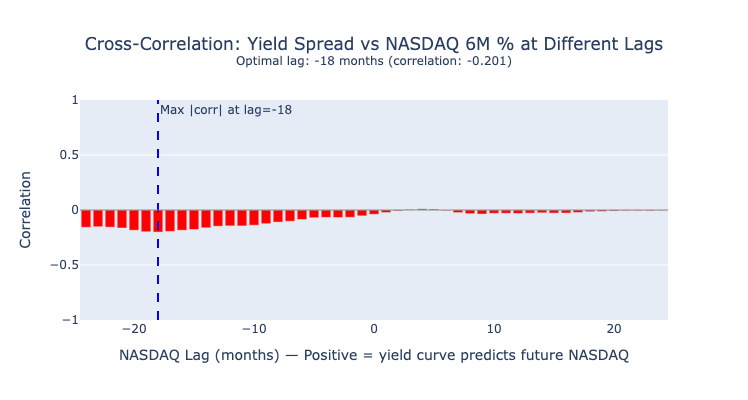


Optimal lag: -18 months
Correlation at optimal lag: -0.201
Interpretation: NASDAQ changes predict yield curve 18 months later


In [5]:
# Cross-correlation analysis: find optimal lag
lags = range(-24, 25)
correlations = []

for lag in lags:
    nasdaq_shifted = combined['NASDAQ 6M %'].shift(-lag)
    valid_data = pd.DataFrame({
        'NASDAQ': nasdaq_shifted,
        'Spread': combined['Yield Spread']
    }).dropna()
    
    if len(valid_data) > 10:
        corr = valid_data['NASDAQ'].corr(valid_data['Spread'])
        correlations.append(corr)
    else:
        correlations.append(np.nan)

# Find optimal lag
max_corr_idx = np.nanargmax(np.abs(correlations))
optimal_lag = list(lags)[max_corr_idx]
optimal_corr = correlations[max_corr_idx]

fig_lag = go.Figure()

fig_lag.add_trace(go.Bar(
    x=list(lags),
    y=correlations,
    marker_color=['green' if c > 0 else 'red' for c in correlations],
    hovertemplate='Lag: %{x} months<br>Correlation: %{y:.3f}<extra></extra>'
))

fig_lag.add_vline(x=optimal_lag, line_dash="dash", line_color="blue", 
                  annotation_text=f"Max |corr| at lag={optimal_lag}")

fig_lag.update_layout(
    title=dict(text=f'Cross-Correlation: Yield Spread vs NASDAQ 6M % at Different Lags<br><sup>Optimal lag: {optimal_lag} months (correlation: {optimal_corr:.3f})</sup>',
               x=0.5),
    xaxis_title='NASDAQ Lag (months) — Positive = yield curve predicts future NASDAQ',
    yaxis_title='Correlation',
    height=400,
    yaxis_range=[-1, 1]
)

fig_lag.add_hline(y=0, line_dash="solid", line_color="gray", opacity=0.5)

fig_lag.show()

print(f"\nOptimal lag: {optimal_lag} months")
print(f"Correlation at optimal lag: {optimal_corr:.3f}")
if optimal_lag > 0:
    print(f"Interpretation: Yield curve changes predict NASDAQ performance {optimal_lag} months later")
elif optimal_lag < 0:
    print(f"Interpretation: NASDAQ changes predict yield curve {-optimal_lag} months later")
else:
    print("Interpretation: Contemporaneous relationship (no predictive lead)")

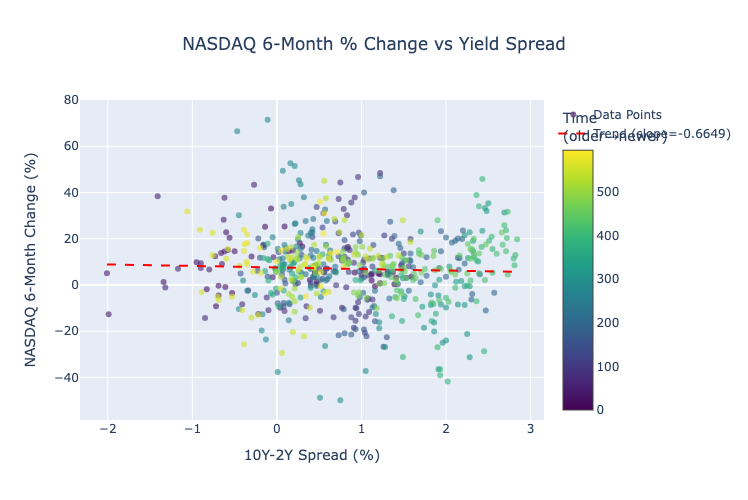

In [6]:
# Scatter plot with regression
mask = ~(np.isnan(combined['Yield Spread']) | np.isnan(combined['NASDAQ 6M %']))
z = np.polyfit(combined.loc[mask, 'Yield Spread'], combined.loc[mask, 'NASDAQ 6M %'], 1)
p = np.poly1d(z)
x_line = np.linspace(combined['Yield Spread'].min(), combined['Yield Spread'].max(), 100)

fig_scatter = go.Figure()

# Color by time
fig_scatter.add_trace(
    go.Scatter(
        x=combined['Yield Spread'],
        y=combined['NASDAQ 6M %'],
        mode='markers',
        marker=dict(
            size=6,
            color=np.arange(len(combined)),
            colorscale='Viridis',
            colorbar=dict(title='Time<br>(older→newer)'),
            opacity=0.6
        ),
        text=combined.index.strftime('%Y-%m'),
        hovertemplate='Date: %{text}<br>Spread: %{x:.2f}%<br>NASDAQ 6M: %{y:.2f}%<extra></extra>',
        name='Data Points'
    )
)

# Regression line
fig_scatter.add_trace(
    go.Scatter(
        x=x_line, y=p(x_line),
        mode='lines',
        line=dict(color='red', dash='dash', width=2),
        name=f'Trend (slope={z[0]:.4f})'
    )
)

fig_scatter.update_layout(
    title=dict(text='NASDAQ 6-Month % Change vs Yield Spread', x=0.5),
    xaxis_title='10Y-2Y Spread (%)',
    yaxis_title='NASDAQ 6-Month Change (%)',
    height=500,
    hovermode='closest'
)

fig_scatter.show()

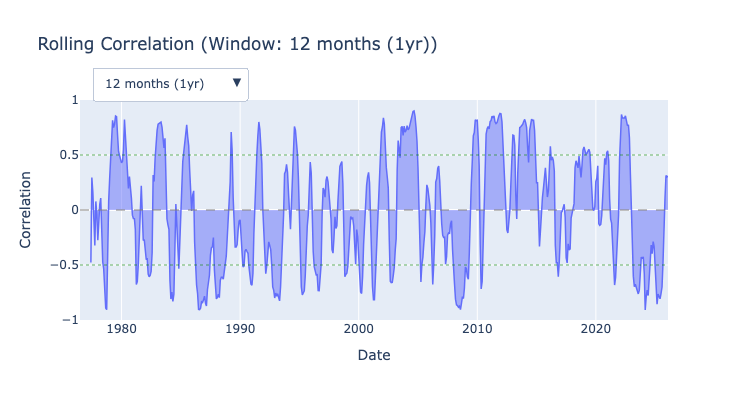

In [7]:
# Interactive rolling correlation with dropdown for window size (in months)
windows = [6, 12, 24, 36, 60, 120]  # 6mo, 1yr, 2yr, 3yr, 5yr, 10yr

fig_corr = go.Figure()

for i, w in enumerate(windows):
    rc = combined['NASDAQ 6M %'].rolling(w).corr(combined['Yield Spread'])
    fig_corr.add_trace(
        go.Scatter(
            x=rc.index, y=rc.values,
            name=f'{w} months',
            visible=(w == 12),
            line=dict(width=1.5),
            fill='tozeroy',
            hovertemplate='%{x}<br>Correlation: %{y:.3f}<extra></extra>'
        )
    )

# Create dropdown buttons
buttons = []
labels = ['6 months', '12 months (1yr)', '24 months (2yr)', '36 months (3yr)', '60 months (5yr)', '120 months (10yr)']
for i, (w, label) in enumerate(zip(windows, labels)):
    visibility = [j == i for j in range(len(windows))]
    buttons.append(
        dict(label=label,
             method='update',
             args=[{'visible': visibility},
                   {'title': f'Rolling Correlation (Window: {label})'}])
    )

fig_corr.update_layout(
    title='Rolling Correlation (Window: 12 months (1yr))',
    xaxis_title='Date',
    yaxis_title='Correlation',
    yaxis_range=[-1, 1],
    height=400,
    updatemenus=[
        dict(
            active=1,
            buttons=buttons,
            direction='down',
            showactive=True,
            x=0.02,
            xanchor='left',
            y=1.15,
            yanchor='top'
        )
    ]
)

fig_corr.add_hline(y=0, line_dash="dash", line_color="gray", opacity=0.5)
fig_corr.add_hline(y=0.5, line_dash="dot", line_color="green", opacity=0.3)
fig_corr.add_hline(y=-0.5, line_dash="dot", line_color="green", opacity=0.3)

fig_corr.show()

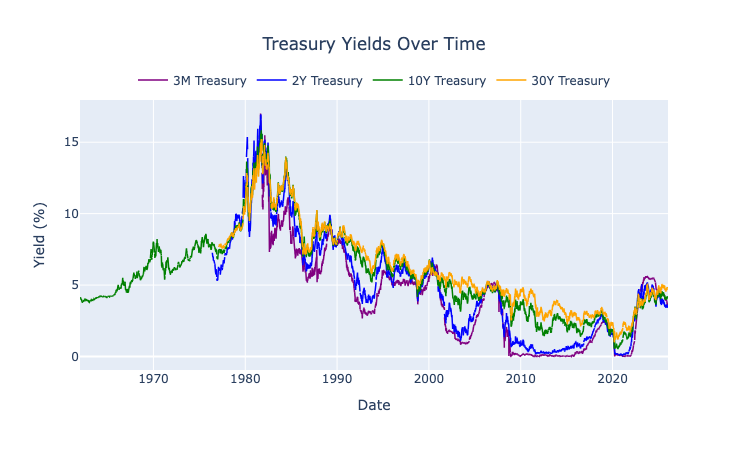

In [8]:
# Treasury yields over time
fig_yields = go.Figure()

colors = {'3M Treasury': 'purple', '2Y Treasury': 'blue', '10Y Treasury': 'green', '30Y Treasury': 'orange'}
for col in ['3M Treasury', '2Y Treasury', '10Y Treasury', '30Y Treasury']:
    if col in yields_df.columns:
        fig_yields.add_trace(
            go.Scatter(x=yields_df.index, y=yields_df[col], name=col,
                       line=dict(color=colors.get(col), width=1.5),
                       hovertemplate='%{x}<br>' + col + ': %{y:.2f}%<extra></extra>')
        )

fig_yields.update_layout(
    title=dict(text='Treasury Yields Over Time', x=0.5),
    xaxis_title='Date',
    yaxis_title='Yield (%)',
    height=450,
    hovermode='x unified',
    legend=dict(orientation='h', yanchor='bottom', y=1.02, xanchor='center', x=0.5)
)

fig_yields.show()

In [9]:
# Yield curve inversion analysis
inversions = combined[combined['Yield Spread'] < 0]
if len(inversions) > 0:
    print(f"Yield Curve Inversion Periods (10Y-2Y < 0):")
    print(f"Total days inverted: {len(inversions)}")
    print(f"\nInversion date ranges:")
    
    inversion_dates = inversions.index.to_series()
    gaps = inversion_dates.diff() > pd.Timedelta(days=5)
    groups = gaps.cumsum()
    
    for group_id in groups.unique():
        group_dates = inversion_dates[groups == group_id]
        duration = (group_dates.iloc[-1] - group_dates.iloc[0]).days + 1
        min_spread = inversions.loc[group_dates.index, 'Yield Spread'].min()
        print(f"  {group_dates.iloc[0].strftime('%Y-%m-%d')} to {group_dates.iloc[-1].strftime('%Y-%m-%d')} ({duration} days, min: {min_spread:.2f}%)")
else:
    print("No yield curve inversions in this period.")

Yield Curve Inversion Periods (10Y-2Y < 0):
Total days inverted: 94

Inversion date ranges:
  1978-08-31 to 1978-08-31 (1 days, min: -0.07%)
  1978-09-30 to 1978-09-30 (1 days, min: -0.14%)
  1978-10-31 to 1978-10-31 (1 days, min: -0.53%)
  1978-11-30 to 1978-11-30 (1 days, min: -0.69%)
  1978-12-31 to 1978-12-31 (1 days, min: -0.83%)
  1979-01-31 to 1979-01-31 (1 days, min: -0.69%)
  1979-02-28 to 1979-02-28 (1 days, min: -0.72%)
  1979-03-31 to 1979-03-31 (1 days, min: -0.61%)
  1979-04-30 to 1979-04-30 (1 days, min: -0.56%)
  1979-05-31 to 1979-05-31 (1 days, min: -0.50%)
  1979-06-30 to 1979-06-30 (1 days, min: -0.16%)
  1979-07-31 to 1979-07-31 (1 days, min: -0.30%)
  1979-08-31 to 1979-08-31 (1 days, min: -0.60%)
  1979-09-30 to 1979-09-30 (1 days, min: -0.66%)
  1979-10-31 to 1979-10-31 (1 days, min: -1.34%)
  1979-11-30 to 1979-11-30 (1 days, min: -0.95%)
  1979-12-31 to 1979-12-31 (1 days, min: -0.90%)
  1980-01-31 to 1980-01-31 (1 days, min: -0.62%)
  1980-02-29 to 1980-02-29

In [10]:
# Summary statistics
print("Summary Statistics")
print("=" * 50)
summary = pd.DataFrame({
    'NASDAQ 6M %': combined['NASDAQ 6M %'].describe(),
    '10Y-2Y Spread': combined['Yield Spread'].describe()
}).round(4)
summary

Summary Statistics


,NASDAQ 6M %,10Y-2Y Spread
count,596.0000,596.0000
mean,6.9742,0.8483
std,15.6750,0.9127
min,-49.8952,-2.0100
25%,-1.5012,0.1900
50%,7.2749,0.7900
75%,14.8446,1.4800
max,71.4527,2.8400
